# Neural Networks

[YouTube A. Karpathy - Spelled Out Intro to NNs](https://www.youtube.com/watch?v=VMj-3S1tku0)

### MicroGrad

[Jupyter Follow Along Link from AK](https://github.com/karpathy/nn-zero-to-hero/tree/master/lectures/micrograd)

In [33]:
# install the package
# pip install micrograd

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
def f(x): 
    return 3*x**2 + 2*x - 1

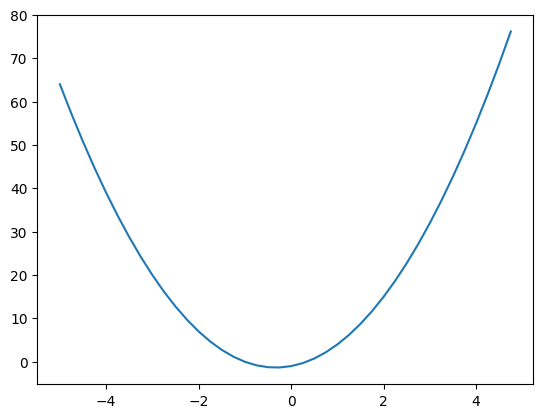

In [35]:
f(3.0)

xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

Above is an expression of a quadratic plotted out using our numpy library. 

Attention to derivatives. Specifically, the limit of h -> 0 (f(x+h)-f(x))/h ... or as we know from finance a measure of the rate of change ... so as we slightly increase x, how is expressed through f(x).

[wiki](https://en.wikipedia.org/wiki/Derivative)



In [36]:
h = .001 # just a small number, but not too small! (memory consideration)
x = 4.0 # random float number

dfdx = (f(x+h) - f(x))/h # the derivative!

print(dfdx)

26.00300000000999


In [37]:
# a more complex example with multiple inputs

a = 3.0
b = -2.0
c = -1.0
d = a * b + c
print(d) 

h = 0.0001

d1 = a * b + c # here we compute the derivative manually
a += h # we increase a by a small amount
d2 = a * b + c # we recompute d

print((d2-d1)/h) # and we see that the derivative is b, as expected



-7.0
-2.0000000000042206


In [71]:


class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other
  
  def __rsub__(self, other):  # other - self
    return other + (-self)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L



Value(data=-8.0)

In [39]:
# code for using graphviz to visualize the computation graph

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

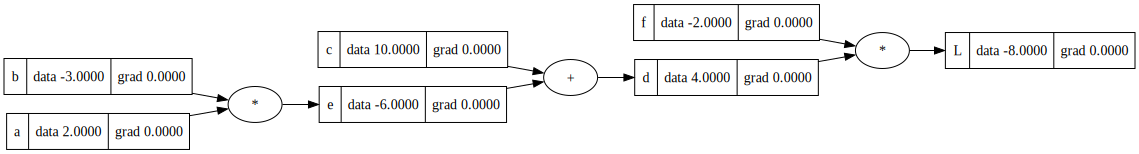

In [40]:
draw_dot(L)


In [41]:
# the gradient represents the slope of the tangent line, or derivative of the variable in relation to the loss function

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()



-8.0
-3.9999999999995595


__The Chain Rule__

[wiki link](https://en.wikipedia.org/wiki/Chain_rule)

If a variable z depends on the variable y, which itself depends on the variable x (that is, y and z are dependent variables), then z depends on x as well, via the intermediate variable y. In this case, the chain rule is expressed as: 

`dz/dx = dz/dy * dy/dx`

Intuitively, the chain rule states that knowing the instantaneous rate of change of z relative to y and that of y relative to x allows one to calculate the instantaneous rate of change of z relative to x as the product of the two rates of change. 

if a bike is traveling at two times the speed of the walking man, and the car is travelling at 4 times the pace of the bike... it can be drawn that the car is travelling eight times faster than the walking man. 

__The Backpropagation Algorithm__

[wiki link](https://en.wikipedia.org/wiki/Backpropagation)

Backpropagation is a method used in artificial neural networks to calculate a gradient that is needed in the calculation of the weights to be used in the network. Backpropagation is shorthand for "the backward propagation of errors," since an error is computed at the output and distributed backwards throughout the network’s layers. It is commonly used to train deep neural networks, a term referring to neural networks with more than one hidden layer.

The backpropagation algorithm works by computing the gradient of the loss function with respect to each weight by the chain rule, computing the gradient one layer at a time, iterating backward from the last layer to avoid redundant calculations of intermediate terms in the chain rule; this is an example of dynamic programming.

__The Gradient Descent Algorithm__

[wiki link](https://en.wikipedia.org/wiki/Gradient_descent)

Gradient descent is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function. To find a local minimum of a function using gradient descent, one takes steps proportional to the negative of the gradient (or approximate gradient) of the function at the current point. If instead one takes steps proportional to the positive of the gradient, one approaches a local maximum of that function; the procedure is then known as gradient ascent.

The gradient descent algorithm in Python uses a learning rate, which is a hyper-parameter that controls how much we are adjusting the weights of our network with respect the loss gradient. The lower the value, the slower we travel along the downward slope. If the learning rate is too low, we may get stuck in a local minimum, and if it is too high, we may jump around and never converge. The goal is to find the sweet spot.

__The Stochastic Gradient Descent Algorithm__

[wiki link](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

Stochastic gradient descent (often abbreviated SGD) is an iterative method for optimizing an objective function with suitable smoothness properties (e.g. differentiable or subdifferentiable). It can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data). Especially in big data applications this reduces the computational burden, achieving faster iterations in trade for a slightly lower convergence rate.

__The Adam Algorithm__

[wiki link](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam)

Adam is an adaptive learning rate optimization algorithm that’s been designed specifically for training deep neural networks. It combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.

Adam is relatively easy to configure where the default configuration parameters do well on most problems.

__The PyTorch Library__

[PyTorch](https://pytorch.org/)

PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab (FAIR). It is free and open-source software released under the Modified BSD license. Although the Python interface is more polished and the primary focus of development, PyTorch also has a C++ interface.

__The PyTorch Autograd Library__

[PyTorch Autograd](https://pytorch.org/docs/stable/autograd.html)

The autograd package provides automatic differentiation for all operations on Tensors. It is a define-by-run framework, which means that your backprop is defined by how your code is run, and that every single iteration can be different.

__The PyTorch Optim Library__

[PyTorch Optim](https://pytorch.org/docs/stable/optim.html)

The optim package in PyTorch abstracts the idea of an optimization algorithm and provides implementations of commonly used optimization algorithms.

__The PyTorch nn Library__

[PyTorch nn](https://pytorch.org/docs/stable/nn.html)

The nn package defines a set of Modules, which are roughly equivalent to neural network layers. A Module receives input Tensors and computes output Tensors, but may also hold internal state such as Tensors containing learnable parameters. The nn package also defines a set of useful loss functions that are commonly used when training neural networks.

__The PyTorch nn.functional Library__

[PyTorch nn.functional](https://pytorch.org/docs/stable/nn.functional.html)

The nn.functional package contains some useful functions which are commonly used for building neural networks. Most of the neural networks expect the input to be a 4D Tensor which is a mini-batch of 3D Tensors of size (channels x height x width). That is, a mini-batch of 2D images with additional channel dimension at index 1. Consequently, nn.functional package contains various useful loss functions, activation functions and convolution functions which you may find useful while building neural networks.

__The PyTorch nn.Module Library__

[PyTorch nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)

Neural networks are made up of layers. A layer is a tensor transformation that may be composed with other layers in a neural network. The torch.nn package defines a set of Modules, which are roughly equivalent to neural network layers. A Module receives input Tensors and computes output Tensors, but may also hold internal state such as Tensors containing learnable parameters. The nn.Module is the base class for all neural network modules.

__The PyTorch nn.Parameter Library__

[PyTorch nn.Parameter](https://pytorch.org/docs/stable/generated/torch.nn.Parameter.html)

A kind of Tensor that is to be considered a module parameter.

Parameters are Tensor subclasses, that have a very special property when used with Module s - when they’re assigned as Module attributes they are automatically added to the list of its parameters, and will appear e.g. in parameters() iterator. Assigning a Tensor doesn’t have such effect. This is because one might want to cache some temporary state, like last hidden state of the RNN, in the model. If there was no such class as Parameter, these temporaries would get registered too.

__The PyTorch nn.Linear Library__

[PyTorch nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

Applies a linear transformation to the incoming data: y = xA^T + b

__The PyTorch nn.Sigmoid Library__

[PyTorch nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)

Applies the element-wise function: Sigmoid(x) = 1 / (1 + exp(-x))

__The PyTorch nn.LogSoftmax Library__

[PyTorch nn.LogSoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html)

Applies the Log(Softmax(x)) function to an n-dimensional input Tensor. The LogSoftmax formulation can be simplified as: LogSoftmax(x) = Log( Softmax(x) ) LogSoftmax(x)_i = log( exp(x_i) / sum_j(exp(x_j) ) )

__The PyTorch nn.NLLLoss Library__

[PyTorch nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)

The negative log likelihood loss. It is useful to train a classification problem with C classes.

If provided, the optional argument weight should be a 1D Tensor assigning weight to each of the classes. This is particularly useful when you have an unbalanced training set.

The input given through a forward call is expected to contain log-probabilities of each class. input has to be a Tensor of size either (minibatch,C) or (minibatch, C, d1, d2, ..., dK) with K ≥ 1 for the K-dimensional case. This criterion expects a class index (0 to C-1) as the target for each value of a 1D tensor of size minibatch

__The PyTorch nn.CrossEntropyLoss Library__

[PyTorch nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.

It is useful when training a classification problem with C classes. If provided, the optional argument weight should be a 1D Tensor assigning weight to each of the classes. This is particularly useful when you have an unbalanced training set.

The input is expected to contain raw, unnormalized scores for each class.

__The PyTorch nn.MSELoss Library__

[PyTorch nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

Creates a criterion that measures the mean squared error (squared L2 norm) between each element in the input x and target y.

__The PyTorch nn.L1Loss Library__

[PyTorch nn.L1Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)

Creates a criterion that measures the mean absolute error (MAE) between each element in the input x and target y.

__The PyTorch nn.Conv2d Library__

[PyTorch nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

Applies a 2D convolution over an input signal composed of several input planes.

In the simplest case, the output value of the layer with input size (N,Cin,H,W), output (N,Cout,Hout,Wout), and kernel size (kh,kw) can be precisely described as:

out(Ni,Co,j,k)=bias(Co)+∑i=0Cin−1∑m=0kh−1∑n=0kw−1weight(Co,i,m,n)×input(Ni,i,stride[0]×j+m,stride[1]×k+n)



(note - this was primarily written and prompted by copilot. I began with the chain rule and then went down the rabbit hole of suggested next prompts by copilot. very neat...)



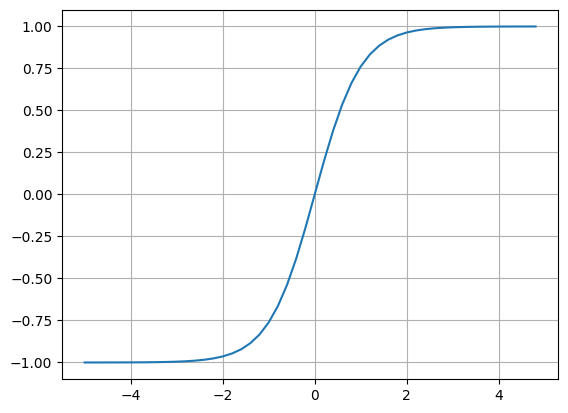

In [42]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

# referred to as a squashing function, because it squashes the input into a range between -1 and 1

# this is a very important property of the tanh function, because it allows us to use it as a replacement for the sigmoid function

In [43]:
# inputs x1,x2
x1 = Value(2.0, label='x1') 
x2 = Value(0.0, label='x2') 
# weights w1,w2
w1 = Value(-3.0, label='w1') # weight of the neuron
w2 = Value(1.0, label='w2') # weight of the neuron
# bias of the neuron
b = Value(6.8813735870195432, label='b') 
x1w1 = x1*w1; x1w1.label = 'x1*w1' # the multiplication of the input and the weight
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2' # 
n = x1w1x2w2 + b; n.label = 'n' # the sum of the multiplication of the input and the weight and the bias
o = n.tanh(); o.label = 'o' # the squashing function

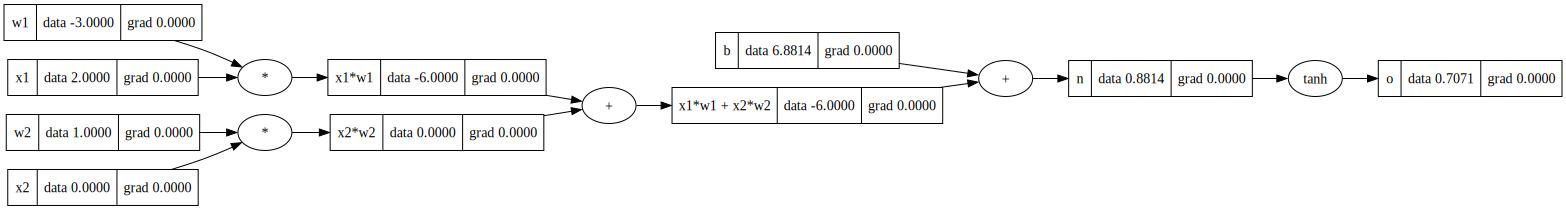

In [44]:
draw_dot(o)

In [45]:
o.backward()

In [46]:
topo = [] # topological order
visited = set() # visited nodes
def build_topo(v): # build the topological order
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo   

[Value(data=6.881373587019543),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [47]:
o.grad = 1.0 # the gradient of the output

o._backward() # backpropagate the gradient
n._backward() # backpropagate the gradient
b._backward() 
x1w1x2w2._backward() 
x2w2._backward()
x1w1._backward()    
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1w1.grad = 0.5
x2w2.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
n.grad = 0.5
o.grad = 1.0
1 - o.data**2

0.4999999999999999

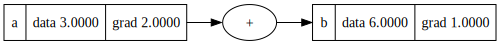

In [48]:

a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

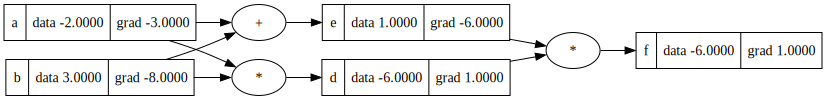

In [49]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [50]:
import torch
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [52]:
class Neuron:
  
  def __init__(self, nin): # nin = number of inputs
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # weights
    self.b = Value(random.uniform(-1,1)) # bias
  
  def __call__(self, x): # 
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # the sum of the multiplication of the weights and the inputs and the bias
    out = act.tanh() # the squashing function
    return out
  
  def parameters(self): # returns the parameters of the neuron
    return self.w + [self.b] # the weights and the bias

class Layer:
  
  def __init__(self, nin, nout): # nin = number of inputs, nout = number of outputs
    self.neurons = [Neuron(nin) for _ in range(nout)] # create nout neurons
  
  def __call__(self, x): 
    outs = [n(x) for n in self.neurons] # compute the output of each neuron
    return outs[0] if len(outs) == 1 else outs # return the output of the layer
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()] # return the parameters of the layer

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts # the size of the network
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # create the layers
  
  def __call__(self, x):
    for layer in self.layers: # compute the output of each layer
      x = layer(x) # the output of the layer is the input of the next layer
    return x 
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()] # return the parameters of the network

In [ ]:


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

draw_dot(n(x))

In [65]:
# example 

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs] # predictions
ypred

[Value(data=0.06642802327038022),
 Value(data=0.5823944084796555),
 Value(data=0.04716448687692094),
 Value(data=0.18440092585226509)]

In [74]:
# loss function - used to get an idea of performance of the network, represented as one number

for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 5.137284012049376
1 4.068444418099956
2 3.830678379486107
3 3.535487556510126
4 3.0791536431497666
5 2.513775376077766
6 2.458761291556249
7 3.730698653450696
8 0.6823465179519856
9 0.08916577107022083
10 0.07329358111515841
11 0.06205504839608172
12 0.05368307635064909
13 0.04721210162829772
14 0.04206692091654113
15 0.03788279207308236
16 0.03441708712223041
17 0.031502131123775666
18 0.029018365402888165
19 0.026878277647431868


In [75]:
ypred


[Value(data=0.9337914807448224),
 Value(data=-0.9004722402157269),
 Value(data=-0.9232234358590753),
 Value(data=0.918181335524789)]